## 0. Setting up the Environment


In [1]:
## impoort labaries 
import os 
import cv2
import mat73
import time
import keras
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage.transform import resize
from keras.models import Sequential
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D

## 1. Data Importing 

In [2]:
SIZE_X = 128
SIZE_Y = 128
SIZE_Z = 3
CLASS_NUM = 6

aug_train_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_train_DF_{}.pkl".format(SIZE_X))
aug_val_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_val_DF_{}.pkl".format(SIZE_X))
aug_test_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_test_DF_{}.pkl".format(SIZE_X))

In [3]:
## Combain the df with the Pitutary & Meningioma types with the dataframe of the Glioma grades (I, II,, IV).
pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).sample(5)

,PID,Label,Image,File
2660,Heatly_dataset_#998,No tumor,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",no964.jpg
5018,HF1538,Glioma VI,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
7397,Heatly_dataset_#998,No tumor,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",no635.jpg
12496,HF1185,Glioma III,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
6365,114018,Meningioma,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",642.mat


In [4]:
pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18612 entries, 0 to 18611
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PID     18612 non-null  object
 1   Label   18612 non-null  object
 2   Image   18612 non-null  object
 3   File    18612 non-null  object
dtypes: object(4)
memory usage: 581.8+ KB


C:\Users\Ma7moud\anaconda3\envs\T-UNet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


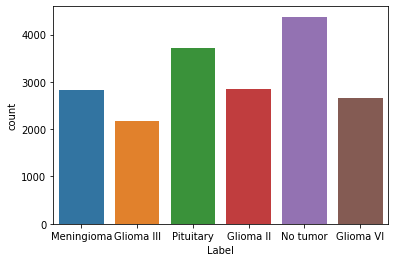

In [5]:
sns.countplot(pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).Label)
plt.show()

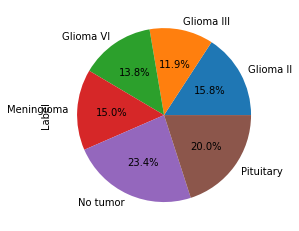

In [6]:
data = aug_train_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

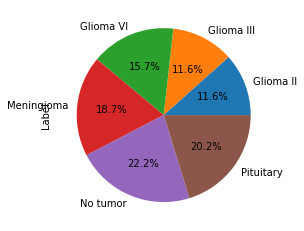

In [7]:
data = aug_val_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

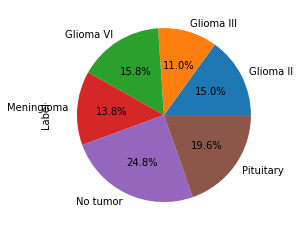

In [8]:
data = aug_test_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

## 2. Data-Preprocessing 

### 2.1 Image Resizing 


### 2.2 Data Augmentation

### 2.3 Grayscale to RGB

In [9]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, :]

In [10]:
aug_train_DF["Image"] = aug_train_DF["Image"].apply(normalize)
aug_val_DF["Image"] = aug_val_DF["Image"].apply(normalize)
aug_test_DF["Image"] = aug_test_DF["Image"].apply(normalize)

### 2.4 Splitting Data into Train, Test, and Validation Sets

In [11]:
y_train = aug_train_DF["Label"]
X_train = aug_train_DF['Image'].tolist()
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)


y_val = aug_val_DF["Label"]
X_val = aug_val_DF['Image'].tolist()
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)

y_test = aug_test_DF["Label"]
X_test = aug_test_DF['Image'].tolist()
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)


In [12]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (13960, 128, 128, 1) | y_train shape: (13960,)
X_val shape  : (1860, 128, 128, 1)  | y_test shape :  (1860,)
X_test shape : (2792, 128, 128, 1)  | y_test shape :  (2792,)


### 2.5 One-Hot Encode the labels 

In [13]:
# saving a copy of the testing labels before one hot encoding
y_test_eval = y_test
# one hot endcoding the labels 
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_val   = pd.get_dummies(y_val)

In [14]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_test shape :",X_test.shape," | y_test shape: ", y_test.shape)
print("X_val shape  :",X_val.shape," | y_val shape : ", y_val.shape)
print("\nTotal number: {}".format(len(aug_train_DF)+len(aug_val_DF)+len(aug_test_DF)))

X_train shape: (13960, 128, 128, 1) | y_train shape: (13960, 6)
X_test shape : (2792, 128, 128, 1)  | y_test shape:  (2792, 6)
X_val shape  : (1860, 128, 128, 1)  | y_val shape :  (1860, 6)

Total number: 18612


In [15]:
y_test

,Glioma II,Glioma III,Glioma VI,Meningioma,No tumor,Pituitary
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,0,1,0,0,0
...,...,...,...,...,...,...
2787,0,0,0,0,0,1
2788,0,0,0,0,0,1
2789,0,0,0,0,1,0
2790,0,1,0,0,0,0


In [17]:
## This Dictionary is used to decode the model's predicted values.  
decode_dict = {0 : "Glioma II", 1 : "Glioma III", 2 : "Glioma VI", 3: "Meningioma", 4: "No tumor", 5: "Pituitary"}

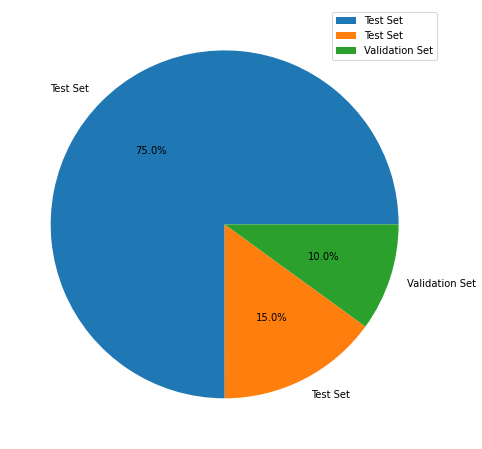

In [18]:
import matplotlib.pyplot as plt
import numpy as np
##  Creating a Pie chart illustrating the percentage of the train, validation, test sets.
Data = np.array([len(y_train), len(y_test), len(y_val)])
mylabels = ["Test Set", "Test Set", "Validation Set"]
plt.figure(figsize=(13, 8))
plt.pie(Data, labels = mylabels, autopct="%.1f%%", )
plt.legend()
plt.show() 

## 3. Models Creation


In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D, Input, Lambda
import tensorflow as tf
import time
from tensorflow.keras import optimizers
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from glob import glob



InceptionV3 = InceptionV3(include_top=False, weights=None, input_shape = (SIZE_X, SIZE_Y, SIZE_Z))

for layer in InceptionV3.layers:
    layer.trainable = False

# Dense Lyers
x = Flatten()(InceptionV3.output)
outLayers = Dense(CLASS_NUM, activation='softmax')(x)

m1 = Model(inputs = InceptionV3.input, outputs = outLayers)

m1.summary()
m1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 4. Model Training


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 40 )

m1.fit(X_train,y_train,epochs=150,batch_size=16, validation_data=(X_val,y_val), callbacks = [early_stop], verbose=1)

Epoch 1/150
873/873 [==============================] - 10s 9ms/step - loss: 0.9500 - accuracy: 0.6181 - val_loss: 0.6757 - val_accuracy: 0.7355
Epoch 2/150
873/873 [==============================] - 7s 8ms/step - loss: 0.5066 - accuracy: 0.7955 - val_loss: 0.4338 - val_accuracy: 0.8199
Epoch 3/150
873/873 [==============================] - 7s 8ms/step - loss: 0.3626 - accuracy: 0.8508 - val_loss: 0.3786 - val_accuracy: 0.8511
Epoch 4/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2981 - accuracy: 0.8804 - val_loss: 0.3088 - val_accuracy: 0.8785
Epoch 5/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2406 - accuracy: 0.9044 - val_loss: 0.3056 - val_accuracy: 0.8952
Epoch 6/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2131 - accuracy: 0.9163 - val_loss: 0.3333 - val_accuracy: 0.8855
Epoch 7/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2001 - accuracy: 0.9221 - val_loss: 0.2457 - val_accuracy: 0.907

In [ ]:
# Get training history
metrics = pd.DataFrame(m1.history.history)

In [ ]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [ ]:
print(results)

In [ ]:
# Save The Trained model along with it training history   
Accuracy = m1.evaluate(X_test, y_test)[-1]
name = str(round(Accuracy, 4))

metrics.to_pickle(os.path.join(results, name+'.pkl'))
m1.save(os.path.join(weights, name + '.h5'))

In [ ]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()

  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'acc_epoch.png'))
plt.show()



In [ ]:
## Get the 
predict_x = m1.predict(X_test) 
predictions = np.argmax(predict_x,axis=1) 

In [ ]:
# Decode the Model's predections  (from [0,1,0,2..] to ['Glioma','Meningioma'...]) of the Test set using the the dictionary 'decode_dict' 
predictions = np.vectorize(decode_dict.get)(predictions)

In [ ]:
print(classification_report(y_test_eval, predictions))

In [ ]:
labels = sorted(aug_test_DF.Label.unique())

cm = pd.DataFrame(confusion_matrix(y_test_eval, predictions), index=labels, columns=labels)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap="PuBu",fmt = 'd')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(os.path.join(results, 'confusion_matrix.png'))
plt.show()